In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

In [11]:
def show_image(window_name, image):
    plt.imshow(image)
    plt.title(window_name)
    plt.show()

In [12]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise( ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [13]:
def find_Coordinatesnew(image):
    print(image.shape)

    hist_x = np.sum(image, axis=0)
    hist_x = smooth(hist_x, 50)

    hist_y = np.sum(image, axis=1)
    hist_y = smooth(hist_y, 50)

    plt.subplot(211)
    plt.plot(hist_x)

    plt.subplot(212)
    plt.plot(hist_y)
    
    # plt.show()

    [Mx,Cx] = (np.max(hist_x), np.argmax(hist_x));
    [My,Cy] = (np.max(hist_y), np.argmax(hist_y));

    C = np.zeros((2,2))

    i = 1
    k = Cx
    while (i>0):
        if(k == 1):
            break
        i = hist_x[k]-(0.1)*Mx;  ###additional term to truncate at 90%of max value
        k=k-1;
    C[0,0] = k+1;

    i = 1
    k = Cx
    while(i>0):
        if k == hist_x.shape[0]:
            break;
        
        i = hist_x[k]-(0.1)*Mx;
        k=k+1
    C[0,1] = k-1

    i = 1
    k = Cy
    while(i>0):
        if k==1:
            break;
        
        i = hist_y[k]-(0.1)*My;
        k=k-1    
    C[1,0] = k+1

    i = 1
    k = Cy
    while(i>0):
        if k == hist_y.shape[0]:
            break
        i = hist_y[k]-(0.1)*My;
        k=k+1
    C[1,1] = k-1

    return C

In [14]:
def deskewing(a):
    # theta = np.linspace(0., 180., max(image.shape), endpoint=False)
    R = radon(a, circle=False)
    # R = np.sum(R,axis=0)
    ind = np.unravel_index(np.argmax(a, axis=None), a.shape)
    # (x,y) = np.argmax(R)
    return ind[1]


In [15]:
def segment_charachters(crop):

    contours, hierarchy = cv2.findContours(crop, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print("num of contours", len(contours))
    perimeter = np.zeros(len(contours))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    chars = []
    mask = np.ones(crop.shape[:2], dtype="uint8") * 255
    for k in range(len(contours)):
        cnt = contours[k]
        perimeter = cv2.arcLength(cnt,True)
        area = cv2.contourArea(cnt)

        if (perimeter > 0.0):
            metric = area/perimeter;
        else:
            metric = 0

        cv2.drawContours(mask, [contours[k]], -1, 0, -1)
        if(metric<= 1.5 or area<= 100 or area>=1500):
            mask = imcomplement(mask)
            crop = cv2.bitwise_and(crop, crop, mask=mask)
        else:
            mask = cv2.dilate(mask, kernel)
            box = cv2.boundingRect(cnt)
            chars.append(box)

    return chars


In [16]:
def imcomplement(img):
    img = (255-img)
    return img

In [17]:
def main():
    MIN_PERIMETER = 500
    MIN_AREA = 100
    MAX_AREA = 1000

    image = cv2.imread('../data/1.jpg')

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(720, 960));
    show_image("step1 gray",image)

    ## edge detection
    edge = cv2.Canny(image,100,200)
    show_image("step2 edge", edge)

    ### Processing Boundries Based on Perimeter of Contours
    contours, hierarchy = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    
    num_contours = len(contours)
    print(f"Number of contours detected : {num_contours}")

    ## Calculate perimeter of each contour and filter out very small contours
    perimeter = np.zeros(num_contours)
    mask = np.ones(image.shape[:2], dtype="uint8") * 255

    for k in range(num_contours):
        perimeter[k] = contours[k].shape[0]
        if perimeter[k] > MIN_PERIMETER:
            cv2.drawContours(mask, [contours[k]], -1, 0, -1)
            edge = cv2.bitwise_and(edge, edge, mask=mask)
            perimeter[k] = 0

    show_image("step3 - contour filtered", edge)

    ### Morphology applied to refine contour boundaries
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    morphed_edges = cv2.morphologyEx(edge, cv2.MORPH_CLOSE, kernel)
    show_image("step4 - morphed", morphed_edges)

    ### Filling the contours
    for k in range(num_contours):
        if perimeter[k] !=0:
            mask = cv2.fillPoly(morphed_edges, pts =[contours[k]], color=(255,255,255))
    show_image("step5 - masked", mask)

    ### Filtered based on Area
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    sizes = stats[1:, -1]; 
    nb_components = nb_components - 1

    img2 = np.zeros((output.shape))
    for i in range(0, nb_components):
        if sizes[i] >= MIN_AREA and sizes[i] <= MAX_AREA:
            img2[output == i + 1] = 255

    show_image("step6 - masked_filtered based on Area", img2)

    #### Cropping the Number Plate Region
    C = find_Coordinatesnew(img2)

    crop = image[int(C[1,0])-20:int(C[1,1])+20,int(C[0,0])-20:int(C[0,1])+20]
    show_image("cropped",crop)

    crop = cv2.adaptiveThreshold(crop,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11,0.1);
    crop = imcomplement(crop)
    show_image("step7 - cropped Number Plate Region",crop)


    ### Deskewing Number plate
    angle = deskewing(crop)
    print(angle)

    from scipy import ndimage    
    rotated = ndimage.rotate(crop, angle) #rotation angle in degree
    # import imutils
    # crop = imutils.rotate_bound(crop, 90-angle)
    show_image("step8 - deskewed image", rotated)

    chars = segment_charachters(crop)
    chars = sorted(chars, key=lambda x: x[0])

    for char in chars:
        char_img = crop[char[1]:char[1]+char[3], char[0]:char[0]+char[2]]
        show_image("character ", char_img)

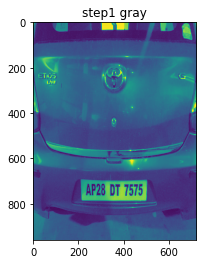

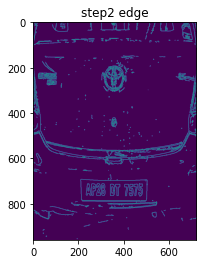

Number of contours detected : 909


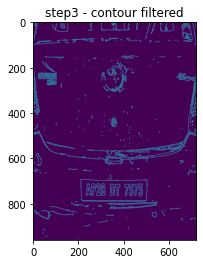

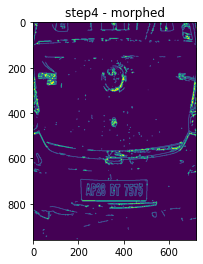

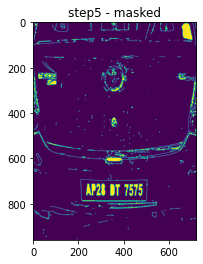

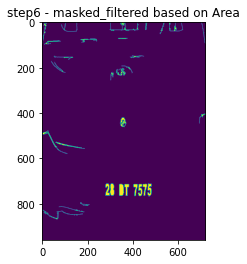

(960, 720)


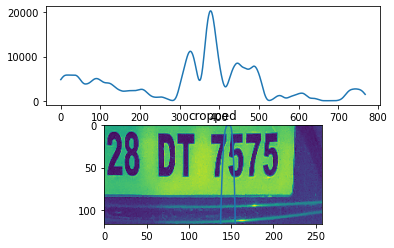

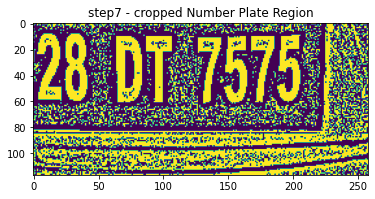

0


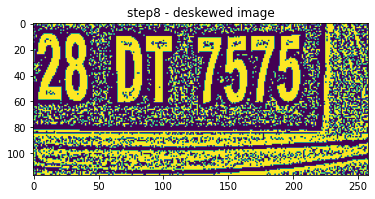

num of contours 1205


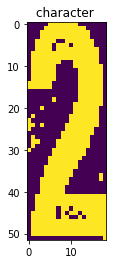

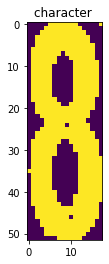

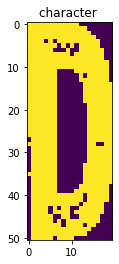

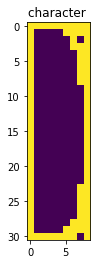

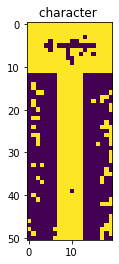

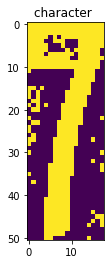

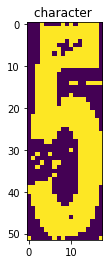

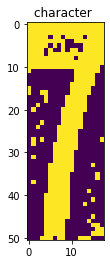

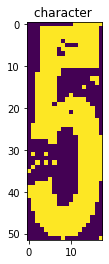

In [18]:
main()